# Dynamic Programming Approach to Leniency Policies in Collusive Corruption



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
import scipy.sparse as sparse
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP
%load_ext itikz

## Corrutpion Model with Leniency

### Constants:

Given the following constants $\psi$ for all periods $t$ and all agents $i$:

 1) Let $b$ be the price from the bribe and $\pi$ the rent extracted from contracts;
 
 2) Let $\alpha$ be the probability of being detected, and if so, convicted with probability $\beta$;
 
 3) Let $\delta \in [0,1] $ be the time discount; 
 
 4) Let $D$ be the interest over the assets $A$;
 
 5) Let $d$ be the decay over the judicial liabilities $L$
 
 6) Let $R$ be the fine redcution for alone self-reporters and $r$ be the fine reduction when both agents self-report before detection;
 
 6) Let $P$ be the fine redcution for alone self-reporters and $p$ be the fine reduction when both agents self-report after detection; and
 
 6) Lastly, let $\eta$ be a relative risk aversion coefficient.
  

In [668]:
#Structural Constants

pi = 4  #rent from the contract
b = 2   #Bribe
d = 1    #Decayment from the liability  
D = 1.2  #Interest over Asset
delta = 0.9  #time discount
eta = 0.5
rho = 1


#Leniency
Re = -1
re = 0.5
Pl = 1
pl = 1

#Probabilities

alpha = 0.08
beta = 0.40
# gamma = 0.05  #try different probabilities for desistence and corrupion


### States and Actions

The state variables $\textbf{x}$ are:

    1) The wealth or the assets $A$ that the agent hold, measured in consumption units;
    2) The liability $L$ which is a function of the criminal history $C$ from the agent, measured in number of crimes; and
    3) The state of the world $S$ in which the agent can be.
  
The actions or controls $\textbf{u}$ are:

    1) The number of consumption units $a$ an agent can save;
    2) Whether to pay a bribe $b$ or not;
    3) Whether to self-report or not. 
    
Since it is not possible to pay a bribe and self-report in the same period. It is possible to condense this decision in a unique varable $ \vartheta$. Consequently, there are the following vectors of states and actions:

\begin{equation*}
	\mathbf{u_t} =
	\begin{bmatrix}
		a_t \\
		\vartheta_t 
	\end{bmatrix}\textrm{, and }
	\mathbf{x_t}=
	\begin{bmatrix}
		A_t\\
		L_t\\
		S_t
	\end{bmatrix}
\end{equation*}


    
The figure bellow shows how the state of the world $S$ change. 



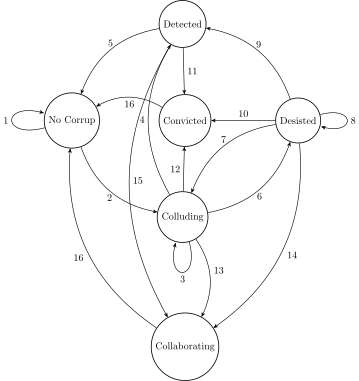

In [626]:
%%itikz
\documentclass[tikz]{standalone}
\begin{document}


\usetikzlibrary{decorations.pathreplacing,angles,quotes,calc,positioning,plotmarks}
\usetikzlibrary{shapes.geometric, arrows, automata,arrows,positioning,calc}
\tikzstyle{startstop} = [rectangle, rounded corners, minimum width=3cm, minimum height=1cm,text centered, draw=black]
\tikzstyle{io} = [trapezium, trapezium left angle=70, trapezium right angle=110, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{process} = [rectangle, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{decision} = [diamond, minimum width=3cm, minimum height=1cm, text centered, draw=black]
\tikzstyle{arrow} = [thick,->,>=stealth]

\begin{tikzpicture}[->, >=stealth', auto, semithick, node distance=2cm]
		\tikzstyle{every state}=[fill=white,draw=black,thick,text=black,scale=1]
		\node[state]    (B)        		       {No Corrup};
		\node[state]    (D)[above right of= B]  at (2.5,2)	     	 {Detected};
		\node[state]    (A)[below right of= B]	at (2.5,-2)	         {Colluding};
		\node[state]    (C)[right of= B]  at (6,0)				 { Desisted };
		\node[state]    (E)[right of= B]  at (2,0)				 { Convicted };
		\node[state]    (F)[right of= B]  at (2,-8)				 { Collaborating };
		\path
		(B) edge[loop left, left]	    	     node{1}   		           (B)
		(B) edge[bend right,below]    			 node{2}        			(A)
		(A) edge[loop below]    				 node{3}            		(A)
		(A) edge[bend left]                			 node{4}            	  (D)
		(D) edge[bend right,above]    				 node{5}            	(B)
		(A) edge [bend right,below]             	   node{6}              (C)
		(C) edge [bend right,above]     	           node{7}              (A)
		(C) edge[loop right]	      				   node{8}             (C)
		(C) edge[bend right,above]    				 node{9}            	(D)
		(C) edge [above]    								 node{10}            	(E)
		(D) edge    								 node{11}            	(E)
		(A) edge    								 node{12}            	(E)
		(F) edge[bend left]                			 node{16}              (B)
		(C) edge[bend left]                			 node{14}              (F)
		(A) edge[bend left]                			 node{13}              (F)
		(D) edge[bend right]                			 node{15}              (F)
		(E) edge[bend right]                			 node{16}              (B);
	\end{tikzpicture}
\end{document}


The state-spaces from $\textbf{x}$ are:

$A = [0,...,\bar{A}]$,
$L = [0,...,\bar{L}]$, and
$S = [s_{nc},s_{c},s_{des},s_{det},s_{acq},s_{con},s_{col},s_{ple}]$.

The control or action-spaces from $\textbf{u}$ are:

$\vartheta = [\vartheta_{nobribe-noreport},\vartheta_{bribe},\vartheta_{report}]$ since bribing and self-reporting are mutually exclusive options, and
$a = [0,...,\bar{a}]$.

In [627]:
# State Variables and Constants

A_bar = 10
A_space = np.arange(0,A_bar + 1,1) #Asset state space

L_bar = 5
L_space = np.arange(0,L_bar + 1,1) #Loability state space

s_nc  = [1,0,0,0,0,0,0,0]
s_cor = [0,1,0,0,0,0,0,0]
s_des = [0,0,1,0,0,0,0,0]
s_det = [0,0,0,1,0,0,0,0]
s_con = [0,0,0,0,1,0,0,0]
s_acq = [0,0,0,0,0,1,0,0]
s_col = [0,0,0,0,0,0,1,0]
s_ple = [0,0,0,0,0,0,0,1]

S_space = [s_nc, s_cor , s_des , s_det ,s_con, s_acq, s_col,s_ple]

#Action Space 
a_bar = A_bar
a_space = np.arange(0,a_bar + 1,1) #saving

vt_n = [0,0]
vt_b = [1,0]
vt_r = [0,1]
vt_space = [vt_n,vt_b,vt_r]

### Laws of Motion:


$ A_{t+1} = D(A_t-c_t-\theta_t +y_t)$  or,

$A_{t+1} =\displaystyle \frac{A_t-c_t-\theta_t +y_t}{D}$, 

For the liability $L$,

$L_{t+1} =  d(L_t + C_t)$  or,

$L_t(s) = C_{t} + \frac{L_{t-1}}{d}$ if $L_{t-1} < \bar{L}$ and $L_t=0$ if $s=s_{nc}$.

Lastly, the change in states $S$ will follow ther rules as enumerated in the figure above:
$$

1  $\theta = 0$;
2 $\theta = b$;
3 $\theta = b$ with probability (1-$\alpha$);
4 with probability $\alpha$;
5 with probability $(1-\beta)$ or self-reported;
6 $\theta = 0$ with probability (1-$\alpha$);
7 $\theta = b$ with probability (1-$\alpha$);
8 $\theta = 0$ with probability (1-$\alpha$);
9 with probability $\alpha$;
10 Reported by the other party;
11 with probability $\beta$ or with probability $(1-\beta)$ and reported by the other party;
12 Reported by the other party;
13 Self-reported;
14 Self-reported;
15 Self-reported (Plea Bargain); and
16 Certainty.



### Outputs from states and actions:

For $y = [0,\pi,F,RF,rf,PF,pf]$ let,

$y_{t}(A,L,S) = \begin{cases}
	0\textrm{   if not colluding}\\
	\pi \textrm{   if colluding}\\
	0\textrm{   if desisted} \\
	 F(L_t)\textrm{   if Convicted } \\
	0 \textrm{ if Acquitted } \\
    RF \textrm{ if Reported alone before detection } \\
    rF \textrm{ if reported simultaneously before detection}\\
    PF \textrm{ if Reported alone after detection } \\
    pF \textrm{ if reported simultaneously after detection}
	\end{cases}$, 

and,

$C_{t}(S) = \begin{cases}
	1 \textrm{   if colluding and } L_{t-1} < \bar{L} \\
	-1 \textrm{   if desisted and }L_{t-1} > 0 \\
    0 \textrm{  else}\end{cases}$,
    
also, for the action of deciding to enter in corrution $\vartheta$,

$\theta_{t}(\vartheta) = \begin{cases}
	b \textrm{  if decided to collude and } i = E \\
	\rho \textrm{  if decided to collude and } i =B  \\
    0 \textrm{  else}\end{cases}$,


### Other functions

The law set fines as:

$F(A,L_t) = min (A, 2 \pi  L_t )$



And the reward function is a CCRA function of $c$:

$u(c) = CCRA(c) = \frac{c^{1- \eta}-1}{1-\eta}$

$r(x,a) = CCRA (A + y(s,L) - a - \theta)$



In [628]:
#Functions:

#Future State Functions  
def L_prime(L,s_prime, vt):
    if s_prime == s_nc: # after detection goes back to zero
        return  0
    elif s_prime == s_des:
        if L > 0: #cannot be less than zero
            return L - 1 #If there is liability then it desapears after each t of desistence
        else:
            return 0 # up to no liability (The particular case in which agent is detected with no liability the fine is 0)
    elif vt == vt_b: # remains only the states in which the agent is detected
        return min((1 + L), L_bar) #apply bondries (L_bar , 1) 
    else: # paid the bribe last period and the states are not desiste or not corrupting
        return L

    
def A_prime(a, D): # For now lets make it simple ##Asset remuneration scheme ## Make a nicer function given A_bar
        return min(int((a+1)*D),A_bar) # always have at least 1 consumption unit to get the game going

#Sprime r
    
#Present Output Functions

def F(A, pi, L): #Function Fine
    return min(A,pi*L*2) #Fines cannot be Bigger than the agents total Assets at t
                 #agents pay at most their total wealth = A - beckerian fine

def y(A, s ,L, Sj): #Output function
    if s == s_cor:
        return pi
    elif s == s_con:
        return - F(A, pi,L)
    elif s == s_col and Sj != s_col:
        return - int(Re*float(F(A, pi,L)))
    elif s == s_col and Sj == s_col:
        return - int(re*float(F(A, pi,L)))
    elif s == s_ple and Sj != s_ple:
        return - int(Pl*float(F(A, pi,L)))
    elif s == s_ple and Sj == s_ple:
        return - int(pl*float(F(A, pi,L)))
    else:
        return 0
    
def theta(vt):
    if vt == vt_b:
        return b
    else:
        return 0
        
#Utility function
def u(A,L,s,Sj,a,vt):
    if A - a - theta(vt) + y(A,s,L,Sj) < 0: #does not appear in the feasible set
        return - np.inf
    if A - a - theta(vt) + y(A,s,L,Sj) == 0: #necessary because log(0)= indef
        return 0
    else:
        return (((A - a - theta(vt) + y(A,s,L,Sj))**(1-eta))-1)/(1-eta) #CRRA function
    

### Strategic Interdependence

Here we assume that agents make decisions simultaneously, so we expect to find a Markov perfect equilibrium for this game. Then we assume that the Bureaucrat always play a greedy action. In other words, the Bureaucrat will always act according to the biggest return in period $t$. This lead to a simple solution to the problem. Or else, the action $\theta$ is only estimated on the basis of current states that the Entrepreneur observe:

$$\vartheta_i = g_i (A,L,s(S_{t-1}, g_j(A,L,S,\psi)),\psi),$$ 

A more robust solution to this problem would imply that Bureaucrats have their own Bellman Equation to solve. In other words, there is a Bellman Equation inside the Entrepreneurs Bellman Equation. This, is oftem called an dynamic programming problem squared (Ljungqvist and Sargent, 2018). However, this would imply in drawing all the states for agent B also.

Here, in order to compute the decison $\vartheta_j$ it is only necessary to know the cost of corruption $\rho$, the bribe $b$ and the probability of detection $\alpha$ and conviction $\beta$. With this simplification, it is not necessaire to calculate all states for $j$, only if the Bureaucrat is Collaborating (Self-reporting and plea bargaining) or not.

In [629]:
def vtj(S,rho,b,alpha,beta,Re,Pl,pi,L,A):
    if (S == s_det or S == s_cor or S == s_des):
        if ((b-rho)*beta*alpha < -Re*F(A, pi, L) and S != s_det) or ((b-rho)*beta < - Pl*F(A, pi, L) and S == s_det):
            return vt_r
        else:
            return vt_n
    else:
        return 0

    
def Sj_prime(vtj,S):
    if vtj == vt_r and S !=s_det :
        return s_col
    elif vtj == vt_r and S ==s_det :
        return s_ple
    else:
        return 0
    
Sj_space = [0,s_col,s_ple]
vtj_space = [0,vt_n,vt_r]

## Building the Reward and Transition Matrices

The state vector space (Also not feasible) $X_{i}(x) = \{[A_{i} = 0 , S_{i}= s_{nc} , L_{i}=0],...,[A_{i}= \bar{A} ,S_{i}=  s_{nc} , L_{i}=0 ],[A_{i} = 0 ,S_{i} =  s_{c} , L_{ij}=0],...,[A_{i}= \bar{A} ,S_{i} = s_{c} ,L_{i}=0], ...[A_{i} = \bar{A} ,S_{i} =  s_{ple} , L_{i}=0],...,[A_{i} = \bar{A} ,S_{i} =  s_{ple} , L_{i}= \bar{L}]   \}$

The verctor space has size $n = 2n_A n_S n_L$, where $n_i$ is the number of possible elements in a state or action for each agent.

The action or control space $U_{i}(x) = \{ [a_{i} = 0 , \vartheta_{i} = \vartheta_n], ... , [a_{i} = \bar{a}, \vartheta_{i} = \vartheta_n],[a_{i} = 0 , \vartheta_{i} = \vartheta_r], ... , [a_{i} = \bar{a},\vartheta_{i} = \vartheta_r] \}$.

The control space has dimension $ m = 2n_a n_\vartheta = 4 n_a$. 


In [630]:
# #Full States Space UNCOMMENT FOR USING FULL SPACES AND SPARCE MATRICES
# X = []

# for i in A_space:
#     for j in L_space:
#         for k in S_space:
#             for l in S_pace:
#                 X.append([i,j,k,l])
# len(X)




In [631]:
# #Full Action Space UNCOMMENT FOR USING FULL SPACES AND SPARCE MATRICES
# U = []

# for i in a_space:
#     for j in vt_space:
#         U.append([i,j])
        
# len(U)


In [632]:
# #Space Action Spcae:  UNCOMMENT FOR USING FULL SPACES AND SPARCE MATRICES

# XU = []

# for i in range(len(X)):
#     for j in range(len(U)):
#         XU.append([X[i][0],X[i][1],X[i][2],U[j][0],U[j][1]]) 
# len(XU)

### Dimension Reduction:

Instead of working with the entire space of controls and states (Sparce Matrices). One can reduce the number of states only to possible movements, so the matrices decrease in dimension.

Here, the hypothesis, for the moment, is that the Bureaucrat is only playing greedy strategies with linear utilities. This might be a irrealistica assumption. In the next secion, the complete model includes another Bellman equation for the Bureaucrat. This simplification implies that it is not necessary to draw all the states for the Bureaucrat, only necessary to draw its actions and furthermore, the states of colluding or not colluding.

There are states that are not possible, and also, there are actions that are not possible in some states. It is possible to summarize the rules as:

1 - Whenever agents are acquited, convicted or they self-report, the liability returns to zero. (If state is not colluding liability is always zero.);

2 - Agents will always have at least 1 liability if they are in state 'colluding' (in corruption);

3 - Agents cannot bribe while detected, collaborating or Self-Reporting;

4 - There must be funds to save;

5 - There must be funds o pay a bribe;


In [633]:
#Feasible Action Space J(x):
#Set of actions allowed for each state x in X
#Dimension Reduction 

X_feasible = [] #set of feasible states corresponding to the action
U_feasible = [] #set of feasible actions corresponding to the space
XU_feasible = [] #creat the vector of the state action pair (for conference)
for i in A_space:
    for j in L_space:
        for k in S_space:
            for kj in Sj_space:
                for m in a_space:
                    for l in vt_space: #buget constraint and state impossibilities:
                        for lj in vtj_space:
                            if  k == s_nc and j !=0:  #If the state is not colluding, the Liability will always be zero
                                pass 
                            elif (k != s_ple and k != s_col and k != s_con) and kj !=0: #Only the states of the bureaucrat plea and collaborating or convicted are considered.. 
                                pass
                            elif not (k == s_cor or k == s_des or k==s_det) and (l == vt_r or lj == vt_r)  : # there can only be report in states cor des det
                                pass
                            elif k == s_cor and j == 0: #Agents will always have at least 1 liability if corruptiong
                                pass
                            elif ((k == s_ple) or (k == s_col) or (k == s_acq) or (k == s_con)) and (l == vt_b or l == vt_r): #Agents Cannot Bribe when detected
                                pass
                            elif k == s_det and l == vt_b: #Agents Cannot Bribe when detected
                                pass
                            elif m > i + y(i,k,j,kj) - theta(l) :  #There must be funds to save
                                pass
                            elif theta (l) > i + y(i,k,j,kj) - m :  #There must be funds to bribe
                                pass
                            elif k == s_col and kj == s_ple: # B and E cannot be in collaborating and self reporting at same time
                                pass
                            elif k == s_ple and kj == s_col:  # B and E cannot be in collaborating and self reporting at same time
                                pass
                            elif lj != vtj(k,rho,b,alpha,beta,Re,Pl,pi,j,i): #Only allowed actions for the bureaucrat are possible
                                pass
                            else:
                                X_feasible.append([i,j,k,kj])
                                U_feasible.append([m,l,lj])
                                XU_feasible.append([i,j,k,kj,m,l,lj])
l = len(X_feasible)
l


4654

In [634]:
#Calculating the indexes (can be done also with pandas.DataFrame.loc[])

#The indices are important to identificate which state when analysing the policy functions

X_indices = [] # It creates an indice or name to each unique state in the list of feasible states

X = [] #new X space, only with feasible states

X_map =[[0,[X_feasible[0][0],X_feasible[0][1],X_feasible[0][2],X_feasible[0][3]]]] # Creates a map that identificate each state in Omega [i].

for i in range(len(X_feasible)):
    if X_feasible[i] == X_feasible[0]:
        X_indices.append(0)
        X =[[X_feasible[0][0],X_feasible[0][1],X_feasible[0][2],X_feasible[0][3]]]
    elif X_feasible[i] != X_feasible[i-1]:
        X_indices.append(X_indices[-1]+1)
        X_map.append([X_indices[i],[X_feasible[i][0],X_feasible[i][1],X_feasible[i][2],X_feasible[i][3]]])
        X.append(X_feasible[i])
    else:
        X_indices.append(X_indices[-1])


U_indices = [] # It creates an indice or name to each unique action in the list of feasible actions


for i in range(len(U_feasible)):
    if U_feasible[i] == U_feasible[0]:
        U_indices.append(0)
    elif U_feasible[i] != U_feasible[i-1]:
        U_indices.append(U_indices[-1]+1)
    else:
        U_indices.append(U_indices[-1])
        
        
n = len(X) #Number of feasible spaces
n

726



Generating the reward vector $R(\textbf{x},\textbf{u})$, of dimension $n \times m$ and the transition matrix $\Omega(\textbf{x},\textbf{u},\textbf{x}')$, of dimension $n \times m \times n$.

$R(\textbf{x},\textbf{u}) =  \begin{bmatrix}
r(X_0,U_0) & \cdots & r(X_0,U_m)\\
\vdots & \ddots & \vdots\\
r(X_n,U_0) & \cdots & r(X_n,U_m) \end{bmatrix}$

where $X_i$ and $U_j$ are the elements from the state and control space, where $i \in [0,n]$ and $j \in [0,m]$. Also,

$\Omega(\textbf{x},\textbf{u},\textbf{x}') = \begin{bmatrix}
 \begin{bmatrix}
p(X_0'|X_0,U_0) & \cdots & p(X_0'|X_0,U_m)\\
\vdots & \ddots & \vdots\\
p(X_0'|X_n,U_0) & \cdots & p(X_0'|X_n,U_m) \end{bmatrix} \\
\vdots \\
\begin{bmatrix}
p(X_n'|X_0,U_0) & \cdots & p(X_n'|X_0,U_m)\\
\vdots & \ddots & \vdots\\
p(X_n'|X_n,U_0) & \cdots & p(X_n'|X_n,U_m) \end{bmatrix} \end{bmatrix}$


In [635]:
#UNCOMENT FOR USING FULL SPARCE MATRIX
# #R(x,u) vector maps the statespace into rewards r

# #Create a Matrix (n x m)
# R = np.zeros((n,m))

# #Populate the Matrix
# for i in range(len(X)):
#     for j in range(len(U)):
#         R[i, j] = r(X[i][0],X[i][1],X[i][2],U[j][0],U[j][1]) 


In [636]:
#UNCOMMENT FOR USING FULL TRANSITION MATRIX
# Transition Matrix

# #Creat a Matrix (n x m x m)

# Omega = np.zeros((n,m,n))

# #Populate the Omega matrix with the probabilities of the future state given the current state
# for k in range(len(X)):
#     for i in range(len(X)):
#         for j in range(len(U)):
#             if X[k][0] == A_prime(U[j][0],D):  #State A' is feasible from an action 'a'
#                 if X[k][1] == L_prime(C(X[i][2]),X[i][1],d): #State L' is feasible from current states 's' and 'L'
#                     if U[j][1]==0: # if there is no bribe paid, the transition is deterministic
#                         Omega[i,j,k] = 1
#                     elif X[k][2]==s_c or s_des: # the states can only be reached a bribe is paid and the crime was not detected
#                         Omega[i,j,k] = 1-alpha
#                     elif x[k][2]==s_detA:
#                         Omega[i,j,k] = alpha*(1-beta)
#                     elif x[k][2]==s_detC:
#                         Omega[i,j,k] = alpha*beta
#                     else:
#                         Omega[i,j,k] = 0        
# len(Omega)

Once Again, it is possible to reduce the dimension from the matrices using only feasible states and actions:

In [637]:

R = []

for i in range(len(X_feasible)):
        R.append(u(X_feasible[i][0],X_feasible[i][1],X_feasible[i][2],X_feasible[i][3],U_feasible[i][0],U_feasible[i][1]))


To build the transition matrix, it is necessary to follow the transition law. Note that transition laws for the states $A$, $L$ and $S_B$ are fully deterministic. The only uncertanty lies int the projection of the pair $(\mathbf{u},S)$ into $S'$. This transition follows the arrows in Figure 1 as described below:

1 $\theta = 0$;

2 $\theta = b$;

3 $\theta = b$ with probability (1-$\alpha$);

4 with probability $\alpha$;

5 with probability $(1-\beta)$ or self-reported;

6 $\theta = 0$ with probability (1-$\alpha$);

7 $\theta = b$ with probability (1-$\alpha$);

8 $\theta = 0$ with probability (1-$\alpha$);

9 with probability $\alpha$;

10 Reported by the other party;

11 with probability $\beta$ or with probability $(1-\beta)$ and reported by the other party;

12 Reported by the other party;

13 Self-reported;

14 Self-reported;

15 Self-reported (Plea Bargain); and

16 Certainty.




In [638]:
#Transition Matrix

# #Creat a Matrix (l x n)

Omega = np.zeros((l,n))

#Populate the Omega matrix with the probabilities of the future state given the current state 

for i in range(l):
    for j in range(n):
            if X[j][0] == A_prime(U_feasible[i][0],D):  #State A' is feasible from an action a
                if X[j][3] == Sj_prime(U_feasible[i][2],X_feasible[i][2]): #Sj is feasible from S and vtj
                    if X[j][1] == L_prime(X_feasible[i][1],X[j][2],U_feasible[i][1]): #State L' is feasible from current states 's' and 'L'
                        if  X_feasible[i][2] == s_nc and X[j][2]==s_nc and U_feasible[i][1] == vt_n : #1
                            Omega[i,j] = 1
                        elif X_feasible[i][2] == s_nc and X[j][2]==s_cor and U_feasible[i][1] == vt_b : #2
                            Omega[i,j] = 1
                        elif X_feasible[i][2] == s_cor and X[j][2]==s_cor and U_feasible[i][1] == vt_b and U_feasible[i][2] == vt_n : #3
                            Omega[i,j] = 1 - alpha
                        elif X_feasible[i][2] == s_cor and X[j][2]==s_det and (U_feasible[i][1] == vt_b or U_feasible[i][1] == vt_n) and U_feasible[i][2] == vt_n : #4
                            Omega[i,j] = alpha
                        elif X_feasible[i][2] == s_det and X[j][2]==s_acq and U_feasible[i][1] == vt_n and U_feasible[i][2] == vt_n : #5
                            Omega[i,j] = 1 - beta
                        elif X_feasible[i][2] == s_cor and X[j][2]==s_des and U_feasible[i][1] == vt_n and U_feasible[i][2] == vt_n: #6
                            Omega[i,j] = 1 - alpha
                        elif X_feasible[i][2] == s_des and X[j][2]==s_cor and U_feasible[i][1] == vt_b and U_feasible[i][2] == vt_n : #7
                            Omega[i,j] = 1 - alpha
                        elif X_feasible[i][2] == s_des and X[j][2]==s_des and U_feasible[i][1] == vt_n and U_feasible[i][2] == vt_n: #8
                            Omega[i,j] = 1 - alpha
                        elif X_feasible[i][2] == s_des and X[j][2]==s_det and (U_feasible[i][1] == vt_b or U_feasible[i][1] == vt_n) and U_feasible[i][2] == vt_n : #9
                            Omega[i,j] = alpha
                        elif X_feasible[i][2] == s_des and X[j][2]==s_con and (U_feasible[i][1] == vt_b or U_feasible[i][1] == vt_n) and U_feasible[i][2] == vt_r : #10
                            Omega[i,j] = 1
                        elif X_feasible[i][2] == s_det and X[j][2]==s_con and U_feasible[i][1] == vt_n and U_feasible[i][2] == vt_n : #11
                            Omega[i,j] = beta                   
                        elif X_feasible[i][2] == s_det and X[j][2]==s_con and U_feasible[i][1] == vt_n and U_feasible[i][2] == vt_r : #11'
                            Omega[i,j] = 1
                        elif X_feasible[i][2] == s_cor and X[j][2]==s_con and (U_feasible[i][1] == vt_b or U_feasible[i][1] == vt_n) and U_feasible[i][2] == vt_r : #12
                            Omega[i,j] = 1
                        elif X_feasible[i][2] == s_cor and X[j][2]==s_col and U_feasible[i][1] == vt_r and (U_feasible[i][2] == vt_n or U_feasible[i][2] == vt_r) : #13
                            Omega[i,j] = 1
                        elif X_feasible[i][2] == s_des and X[j][2]==s_col and U_feasible[i][1] == vt_r and (U_feasible[i][2] == vt_n or U_feasible[i][2] == vt_r) : #14
                            Omega[i,j] = 1
                        elif X_feasible[i][2] == s_det and X[j][2]==s_ple and U_feasible[i][1] == vt_r and (U_feasible[i][2] == vt_n or U_feasible[i][2] == vt_r) : #15
                            Omega[i,j] = 1
                        elif (X_feasible[i][2] == s_col or X_feasible[i][2] == s_ple or X_feasible[i][2] == s_acq or X_feasible[i][2] == s_con) and X[j][2]==s_nc: # 16
                            Omega[i,j] = 1
                        else:
                            0
                            
test = []
fails = []
for i in range(len(Omega)):
    test.append(Omega[i].sum())
    if round(Omega[i].sum(),4) != 1:
        fails.append(i)
if len(fails) == 0:
    print('sucess: Omega shape  ->', Omega.shape)
else:
    fails


#PS: Note that the number of conditions must equal the number of possible movements (arrows) in the Figure 1 + 1.

sucess: Omega shape  -> (4654, 726)


In [639]:
XU_feasible[503]

[2, 4, [0, 1, 0, 0, 0, 0, 0, 0], 0, 2, [1, 0], [0, 0]]

In [640]:
for i in range(len(Omega[4])):
    if Omega[3][i] !=0:
        print(i,Omega[3][i])

69 0.4
72 0.6


In [641]:
X[72]

[1, 0, [0, 0, 0, 0, 0, 1, 0, 0], 0]

In [642]:
for i in range(len(Omega)):
    if Omega[i].sum()!=1:
        print(i,Omega[i].sum())


In [643]:
# print('Example: From the state-action pair  XU_feasible[1000], or ', XU_feasible[1000],
#       ' there are positive probabilities of Omega[1000][253] = ', Omega[1000][253],', Omega[1000][254]=' ,
#       Omega[1000][254] ,', Omega[1000][259]= ',Omega[1000][259],
#      'to go to the states X[253] = ',X[253],', X[253] = ',X[254],', X[253] = ',X[259])

### The agent's problem:

\begin{equation}
\max E_0 \sum_{t=0}^{\infty} \delta^t u(c_t)
\label{a1}
\end{equation}


$$\textrm{s.t.  } A_{t+1}  = D(A_t-c_t-\theta_t +y_t)$$

$$L_{t+1}  = d (L_t + C_t)$$

$$S_{t+i} = f(S_t).$$


It is possible to rewrite the agent's problem as a value function, such as:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{u}} \{ u(\mathbf{x}) + \delta E[V(\mathbf{x'})|\mathbf{x},\mathbf{u}]\}$$

This is quivallento to:

$$V(\mathbf{x}) = \max_{\mathbf{x},\mathbf{x'},\mathbf{u}} \{ R(\mathbf{x},\mathbf{u}) + \delta V(\mathbf{x'}) \Omega(\mathbf{x'},\mathbf{u},\mathbf{x})\}$$


This problem can be solved by iterating the matrix $\Omega$ through the reward function $R$.

To solve this dynamic prgraming problem, we can use he routine quantecon.markov.DiscriteDP from quantecon.org. For this specific example, I am solving the problem using the method of policy iteration.

In [644]:
#creat the QE instance for solution 

ddp =qe.markov.DiscreteDP(R, Omega, delta, X_indices, U_indices)

In [645]:
results = ddp.solve(method='policy_iteration')

In [646]:
#results.sigma #translate the states

In [647]:
#results.v

In [648]:
stationary = results.mc.stationary_distributions
#stationary

In [649]:
#Stationary equilibrium
for i in range(len(stationary[0])):
    if stationary[0,i] != 0:
        print(round(stationary[0,i],4), X[i])
        
#how to make it a zero summ game?

0.0252 [1, 0, [1, 0, 0, 0, 0, 0, 0, 0], 0]
0.0629 [1, 1, [0, 1, 0, 0, 0, 0, 0, 0], 0]
0.002 [1, 2, [0, 0, 0, 0, 1, 0, 0, 0], 0]
0.003 [1, 2, [0, 0, 0, 0, 0, 1, 0, 0], 0]
0.0019 [1, 3, [0, 0, 0, 0, 1, 0, 0, 0], 0]
0.0028 [1, 3, [0, 0, 0, 0, 0, 1, 0, 0], 0]
0.0017 [1, 4, [0, 0, 0, 0, 1, 0, 0, 0], 0]
0.0026 [1, 4, [0, 0, 0, 0, 0, 1, 0, 0], 0]
0.0196 [1, 5, [0, 0, 0, 0, 1, 0, 0, 0], 0]
0.0294 [1, 5, [0, 0, 0, 0, 0, 1, 0, 0], 0]
0.0629 [2, 0, [1, 0, 0, 0, 0, 0, 0, 0], 0]
0.0579 [4, 2, [0, 1, 0, 0, 0, 0, 0, 0], 0]
0.005 [4, 2, [0, 0, 0, 1, 0, 0, 0, 0], 0]
0.049 [6, 4, [0, 1, 0, 0, 0, 0, 0, 0], 0]
0.0043 [6, 4, [0, 0, 0, 1, 0, 0, 0, 0], 0]
0.2699 [6, 5, [0, 1, 0, 0, 0, 0, 0, 0], 0]
0.0235 [6, 5, [0, 0, 0, 1, 0, 0, 0, 0], 0]
0.0532 [8, 3, [0, 1, 0, 0, 0, 0, 0, 0], 0]
0.0046 [8, 3, [0, 0, 0, 1, 0, 0, 0, 0], 0]
0.2933 [10, 5, [0, 1, 0, 0, 0, 0, 0, 0], 0]
0.0255 [10, 5, [0, 0, 0, 1, 0, 0, 0, 0], 0]


 ## Plotting the Histograms
 
From the code above, it is possible to write a class in order to plot different histograms for different combination of parameters:

In [122]:
#Writing the class


class Leniency:

    def __init__(self, rho = 1,pi=4, b = 2, d = 1, D = 1.2, delta = 0.9, alpha = 0.08, beta = 0.4, A_bar = 10, L_bar = 5, eta = 0.8, Re = 0, re = 0.6, Pl = 0.4, pl = 0.75):
        """
        Set up an instance to run the Quantecon routine of discrete dynamic programin.
        
        """
        self.rho, self.pi, self.b, self.d, self.D, self.delta, self.alpha, self.beta, self.A_bar, self.L_bar, self.eta, self.Re, self.re, self.Pl, self.pl = rho, pi , b , d, D, delta, alpha, beta, A_bar, L_bar, eta, Re, re, Pl, pl
        

        #Standart Variables
        #Structural Constants

        # pi = 4  #rent from the contract
        # b = 2   #Bribe
        # d = 1    #Decayment from the liability  
        # D = 1.2  #Interest over Asset
        # delta = 0.9  #time discount
        # eta = 0.5

        # #Leniency
        # Re = 0
        # re = 0.6
        # Pl = 0.4
        # pl = 0.75

        # #Probabilities

        # alpha = 0.08
        # beta = 0.60
        # # gamma = 0.05  #try different probabilities for desistence and corrupion

        # State Variables and Constants

        self.A_space = np.arange(0,self.A_bar + 1,1) #Asset state space
        self.L_space = np.arange(0,self.L_bar + 1,1) #Loability state space
        
        #S space

        self.s_nc  = [1,0,0,0,0,0,0,0]
        self.s_cor = [0,1,0,0,0,0,0,0]
        self.s_des = [0,0,1,0,0,0,0,0]
        self.s_det = [0,0,0,1,0,0,0,0]
        self.s_con = [0,0,0,0,1,0,0,0]
        self.s_acq = [0,0,0,0,0,1,0,0]
        self.s_col = [0,0,0,0,0,0,1,0]
        self.s_ple = [0,0,0,0,0,0,0,1]

        self.S_space = [self.s_nc, self.s_cor , self.s_des , self.s_det ,self.s_con, self.s_acq, self.s_col,self.s_ple]

        #Action Space 
        self.a_bar = self.A_bar
        self.a_space = np.arange(0,self.a_bar + 1,1) #saving

        self.vt_n = [0,0]
        self.vt_b = [1,0]
        self.vt_r = [0,1]
        self.vt_space = [self.vt_n,self.vt_b,self.vt_r]
        
        
        #Bureaucrat State Space
        self.Sj_space = [0,self.s_col,self.s_ple]
        self.vtj_space = [0, self.vt_n,self.vt_r]

        #Feasible Action Space J(x):
        #Set of actions allowed for each state x in X
        #Dimension Reduction 

        self.X_feasible = [] #set of feasible states corresponding to the action
        self.U_feasible = [] #set of feasible actions corresponding to the space
        self.XU_feasible = [] #creat the vector of the state action pair (for conference)
        for i in self.A_space:
            for j in self.L_space:
                for k in self.S_space:
                    for kj in self.Sj_space:
                        for m in self.a_space:
                            for l in self.vt_space: #buget constraint and state impossibilities:
                                for lj in self.vtj_space:
                                    if  k == self.s_nc and j !=0:  #If the state is not colluding, the Liability will always be zero
                                        pass 
                                    elif (k != self.s_ple and k != self.s_col and k != self.s_con) and kj !=0: #Only the states of the bureaucrat plea and collaborating or convicted are considered.. 
                                        pass
                                    elif not (k == self.s_cor or k == self.s_des or k==self.s_det) and (l == self.vt_r or lj == self.vt_r)  : # there can only be report in states cor des det
                                        pass
                                    elif k == self.s_cor and j == 0: #Agents will always have at least 1 liability if corruptiong
                                        pass
                                    elif ((k == self.s_ple) or (k == self.s_col) or (k == self.s_acq) or (k == self.s_con)) and (l == self.vt_b or l == self.vt_r): #Agents Cannot Bribe when detected
                                        pass
                                    elif k == self.s_det and l == self.vt_b: #Agents Cannot Bribe when detected
                                        pass
                                    elif i + self.y(i,k,j,kj,self.pi) - self.theta(l) < m:  #There must be funds to save
                                        pass
                                    elif i + self.y(i,k,j,kj,self.pi) - m < self.theta(l):  #There must be funds to bribe
                                        pass
                                    elif k == self.s_col and kj == self.s_ple: # B and E cannot be in collaborating and self reporting at same time
                                        pass
                                    elif k == self.s_ple and kj == self.s_col:  # B and E cannot be in collaborating and self reporting at same time
                                        pass
                                    elif lj != self.vtj(k,self.rho,self.b,self.alpha,self.beta,self.Re,self.Pl,self.pi,j,i): #Only allowed actions for the bureaucrat are possible
                                        pass
                                    else:
                                        self.X_feasible.append([i,j,k,kj])
                                        self.U_feasible.append([m,l,lj])
                                        self.XU_feasible.append([i,j,k,kj,m,l,lj])
        self.l = len(self.X_feasible)       

        #Calculating the indexes (can be done also with pandas.DataFrame.loc[])

        #The indices are important to identificate which state when analysing the policy functions

        self.X_indices = [] # It creates an indice or name to each unique state in the list of feasible states

        self.X = [] #new X space, only with feasible states

        #X_map =[[0,[X_feasible[0][0],X_feasible[0][1],X_feasible[0][2]]]] # Creates a map that identificate each state in Omega [i].

        for i in range(len(self.X_feasible)):
            if self.X_feasible[i] == self.X_feasible[0]:
                self.X_indices.append(0)
                self.X =[[self.X_feasible[0][0],self.X_feasible[0][1],self.X_feasible[0][2],self.X_feasible[0][3]]]
            elif self.X_feasible[i] != self.X_feasible[i-1]:
                self.X_indices.append(self.X_indices[-1]+1)
                #self.X_map.append([self.X_indices[i],[self.X_feasible[i][0],self.X_feasible[i][1],self.X_feasible[i][2],self.X_feasible[i][3]]])
                self.X.append(self.X_feasible[i])
            else:
                self.X_indices.append(self.X_indices[-1])


        self.U_indices = [] # It creates an indice or name to each unique action in the list of feasible actions


        for i in range(len(self.U_feasible)):
            if self.U_feasible[i] == self.U_feasible[0]:
                self.U_indices.append(0)
            elif self.U_feasible[i] != self.U_feasible[i-1]:
                self.U_indices.append(self.U_indices[-1]+1)
            else:
                self.U_indices.append(self.U_indices[-1])


        self.n = len(self.X) #Number of feasible spaces


        
        self.R = []

        for i in range(len(self.X_feasible)):
                self.R.append(self.u(self.X_feasible[i][0],self.X_feasible[i][1],self.X_feasible[i][2],self.X_feasible[i][3],self.U_feasible[i][0],self.U_feasible[i][1]))

        #Transition Matrix

        # #Creat a Matrix (l x n)

        self.Omega = np.zeros((self.l,self.n))

        #Populate the Omega matrix with the probabilities of the future state given the current state 

        for i in range(self.l):
            for j in range(self.n):
                    if self.X[j][0] == self.A_prime(self.U_feasible[i][0],self.D):  #State A' is feasible from an action a
                        if self.X[j][3] == self.Sj_prime(self.U_feasible[i][2],self.X_feasible[i][2]): #Sj is feasible from S and vtj feasible from S and vtj
                            if self.X[j][1] == self.L_prime(self.U_feasible[i][1],self.X_feasible[i][1],self.X[j][2]): #State L' is feasible from current states 's' and 'L'
                                if  self.X_feasible[i][2] == self.s_nc and self.X[j][2]==self.s_nc and self.U_feasible[i][1] == self.vt_n : #1
                                    self.Omega[i,j] = 1
                                elif self.X_feasible[i][2] == self.s_nc and self.X[j][2]==self.s_cor and self.U_feasible[i][1] == self.vt_b : #2
                                    self.Omega[i,j] = 1
                                elif self.X_feasible[i][2] == self.s_cor and self.X[j][2]==self.s_cor and self.U_feasible[i][1] == self.vt_b and self.U_feasible[i][2] == self.vt_n : #3
                                    self.Omega[i,j] = 1 - self.alpha
                                elif self.X_feasible[i][2] == self.s_cor and self.X[j][2]==self.s_det and (self.U_feasible[i][1] == self.vt_b or self.U_feasible[i][1] == self.vt_n) and self.U_feasible[i][2] == self.vt_n : #4
                                    self.Omega[i,j] = self.alpha
                                elif self.X_feasible[i][2] == self.s_det and self.X[j][2]==self.s_acq and self.U_feasible[i][1] == self.vt_n and self.U_feasible[i][2] == self.vt_n : #5
                                    self.Omega[i,j] = 1 - self.beta
                                elif self.X_feasible[i][2] == self.s_cor and self.X[j][2]==self.s_des and self.U_feasible[i][1] == self.vt_n and self.U_feasible[i][2] == self.vt_n: #6
                                    self.Omega[i,j] = 1 - self.alpha
                                elif self.X_feasible[i][2] == self.s_des and self.X[j][2]==self.s_cor and self.U_feasible[i][1] == self.vt_b and self.U_feasible[i][2] == self.vt_n : #7
                                    self.Omega[i,j] = 1 - self.alpha
                                elif self.X_feasible[i][2] == self.s_des and self.X[j][2]==self.s_des and self.U_feasible[i][1] == self.vt_n and self.U_feasible[i][2] == self.vt_n: #8
                                    self.Omega[i,j] = 1 - self.alpha
                                elif self.X_feasible[i][2] ==self.s_des and self.X[j][2]==self.s_det and (self.U_feasible[i][1] == self.vt_b or self.U_feasible[i][1] == self.vt_n) and self.U_feasible[i][2] == self.vt_n : #9
                                    self.Omega[i,j] = self.alpha
                                elif self.X_feasible[i][2] == self.s_des and self.X[j][2]==self.s_con and (self.U_feasible[i][1] == self.vt_b or self.U_feasible[i][1] == self.vt_n) and self.U_feasible[i][2] == self.vt_r : #10
                                    self.Omega[i,j] = 1
                                elif self.X_feasible[i][2] == self.s_det and self.X[j][2]==self.s_con and self.U_feasible[i][1] == self.vt_n and self.U_feasible[i][2] == self.vt_n : #11
                                    self.Omega[i,j] = self.beta                   
                                elif self.X_feasible[i][2] == self.s_det and self.X[j][2]==self.s_con and self.U_feasible[i][1] == self.vt_n and self.U_feasible[i][2] == self.vt_r : #11'
                                    self.Omega[i,j] = 1
                                elif self.X_feasible[i][2] == self.s_cor and self.X[j][2]==self.s_con and (self.U_feasible[i][1] == self.vt_b or self.U_feasible[i][1] == self.vt_n) and self.U_feasible[i][2] == self.vt_r : #12
                                    self.Omega[i,j] = 1
                                elif self.X_feasible[i][2] == self.s_cor and self.X[j][2]==self.s_col and self.U_feasible[i][1] == self.vt_r and (self.U_feasible[i][2] == self.vt_n or self.U_feasible[i][2] == self.vt_r) : #13
                                    self.Omega[i,j] = 1
                                elif self.X_feasible[i][2] == self.s_des and self.X[j][2]==self.s_col and self.U_feasible[i][1] == self.vt_r and (self.U_feasible[i][2] == self.vt_n or self.U_feasible[i][2] == self.vt_r) : #14
                                    self.Omega[i,j] = 1
                                elif self.X_feasible[i][2] == self.s_det and self.X[j][2]==self.s_ple and self.U_feasible[i][1] == self.vt_r and (self.U_feasible[i][2] == self.vt_n or self.U_feasible[i][2] == self.vt_r) : #15
                                    self.Omega[i,j] = 1
                                elif (self.X_feasible[i][2] == self.s_col or self.X_feasible[i][2] == self.s_ple or self.X_feasible[i][2] == self.s_acq or self.X_feasible[i][2] == self.s_con) and self.X[j][2]==self.s_nc: # 16
                                    self.Omega[i,j] = 1
                                else:
                                    0
        
#     #Functions:
#     #Future State Functions  
#     def L_prime(self,theta,L,s_prime):
#         if s_prime == self.s_nc: # after detection goes back to zero
#             return  0
#         else:
#             if theta == 0:
#                 if s_prime == self.s_des:
#                     if L > 0: #cannot be less than zero
#                         return L - 1 #If there is liability then it desapears after each t of desistence
#                     else:
#                         return 0 # up to no liability (The particular case in which agent is detected with no liability the fine is 0)
#                 else: # remains only the states in which the agent is detected
#                     return L
#             else: # paid the bribe last period and the states are not desiste or not corrupting
#                 return min((int(1 + L)*self.d) , self.L_bar) #apply bondries (L_bar , 1) 

    
#     def A_prime(self,a): # For now lets make it simple ##Asset remuneration scheme ## Make a nicer function given A_bar
#             return min(int((a+1)*self.D),self.A_bar) # always have at least 1 consumption unit to get the game going

#     #Present Output Functions

#     def F(self, A, L): #Function Fine
#         return min(A,self.pi*L*2) #Fines cannot be Bigger than the agents total Assets at t
#                      #agents pay at most their total wealth = A - beckerian fine

#     def y(A, s ,L): #Output function
#         if s == self.s_c:
#             return self.pi
#         elif s == self.s_detC:
#             return - F(A, self.pi,L) 
#         else:
#             return 0

#     #Reward function
#     def r(self,A,L,s,a,theta):
#         if A - a - theta + y(A,s,L) < 0: #does not appear in the feasible set
#             return - np.inf
#         if A - a - theta + y(A,s,L) == 0: #necessary because log(0)= indef
#             return 0
#         else:
#                 return (((A - a - theta + y(A,s,L))**(1-self.eta))-1)/(1-self.eta) #CRRA function
        
    
    
    
    #Functions:

    #Future State Functions  
    def L_prime(self, vt,L,s_prime):
        if s_prime == self.s_nc: # after detection goes back to zero
            return  0
        elif s_prime == self.s_des:
            if L > 0: #cannot be less than zero
                return L - 1 #If there is liability then it desapears after each t of desistence
            else:
                return 0 # up to no liability (The particular case in which agent is detected with no liability the fine is 0)
        elif vt == self.vt_b: # remains only the states in which the agent is detected
            return min((1 + L), self.L_bar) #apply bondries (L_bar , 1) 
        else: # paid the bribe last period and the states are not desiste or not corrupting
            return L
        
    def A_prime(self, a, D): # For now lets make it simple ##Asset remuneration scheme ## Make a nicer function given A_bar
            return min(int((a+1)*D),self.A_bar) # always have at least 1 consumption unit to get the game going

        #Sprime r

    #Present Output Functions

    def F(self, A, pi, L): #Function Fine
        return min(A,pi*L*2) #Fines cannot be Bigger than the agents total Assets at t
                     #agents pay at most their total wealth = A - beckerian fine

    def y(self, A, s ,L, Sj,pi): #Output function
        if s == self.s_cor:
            return pi
        elif s == self.s_con:
            return - self.F(A, pi,L)
        elif s == self.s_col and Sj != self.s_col:
            return - int(self.Re*float(self.F(A, pi,L)))
        elif s == self.s_col and Sj == self.s_col:
            return - int(self.re*float(self.F(A, pi,L)))
        elif s == self.s_ple and Sj != self.s_ple:
            return  - int(self.Pl*float(self.F(A, pi,L)))
        elif s == self.s_ple and Sj == self.s_ple:
            return - int(self.pl*float(self.F(A, pi,L)))
        else:
            return 0

    def theta(self, vt):
        if vt == self.vt_b:
            return self.b
        else:
            return 0

    #Utility function
    def u(self, A,L,s,Sj,a,vt):
        if A - a - self.theta(vt) + self.y(A,s,L,Sj,self.pi) < 0: #does not appear in the feasible set
            return - np.inf
        if A - a - self.theta(vt) + self.y(A,s,L,Sj,self.pi) == 0: #necessary because log(0)= indef
            return 0
        else:
            return (((A - a - self.theta(vt) + self.y(A,s,L,Sj,self.pi))**(1-self.eta))-1)/(1-self.eta) #CRRA function

        
    def vtj(self, S,rho,b,alpha,beta,Re,Pl,pi,L,A):
        if (S == self.s_det or S == self.s_cor or S == self.s_des):
            if ((b-rho)*beta*alpha < -Re*self.F(A, pi, L) and S != self.s_det) or ((b-rho)*beta < -Pl*self.F(A, pi, L) and S == self.s_det):
                return self.vt_r
            else:
                return self.vt_n
        else:
            return 0


    def Sj_prime(self, vtj,S):
        if vtj == self.vt_r and S !=self.s_det :
            return self.s_col
        elif vtj == self.vt_r and S == self.s_det :
            return self.s_ple
        else:
            return 0



        
        

In [123]:

def histogram(instance, title):
    '''
    Build a the bin for the plot function for the instance from SimpleCorruption() and a title strig .
    
    '''
    ddp1 = qe.markov.DiscreteDP(instance.R, instance.Omega, instance.delta, instance.X_indices, instance.U_indices)
    results1 = ddp1.solve(method='policy_iteration')
    stationary1 = results1.mc.stationary_distributions
    
    #Stationary equilibrium

    raw1 = []

    for i in range(len(stationary1[0])):
        if stationary1[0,i] != 0:
            raw1.append([stationary1[0,i],instance.X[i]])

#     if round(np.asarray(raw1).sum(axis=0)[0],5) == 1: #test if probabilities summ up to one
#         print('Success')
    #constructing the bins


    #Create the state A frequency

    A_dist1 = np.zeros(instance.A_bar)

    for i in range(len(raw1)):
        for j in range(instance.A_bar):
            if raw1[i][1][0] == j:
                A_dist1[j] = A_dist1[j] + raw1[i][0]

    #Create the state S frequency

    S_dist1 = np.zeros(len(instance.S_space))

    for i in range(len(raw1)):
        for j in range(len(instance.S_space)):
            if raw1[i][1][2] == instance.S_space[j]:
                S_dist1[j] = S_dist1[j] + raw1[i][0]
                
    space_dict = ['No \n Corruption', 'Corruption', 'Desistence','Detection','Convicted','Acquitted', 'Collaborating', 'Plea- \n Bargaining']

    fig, ax = plt.subplots(1, 2, figsize=(22,3))

    ax[0].bar( 1 + np.arange(instance.A_bar),A_dist1, 1, align='center',color = 'steelblue', zorder=3)
    #ax.grid(True,alpha=0.5, linestyle='--',zorder=0)
    ax[0].set_xticks(instance.A_space)
    ax[0].set_xticklabels(instance.A_space)
    ax[0].set_ylim(bottom= 0 , top = 1)
    ax[0].set_xlabel('Savings')   
    ax[0].set_ylabel('Frequency')
    ax[0].set_title(title)


    ax[1].bar( np.arange(len(instance.S_space)),S_dist1, 1, align='center',color = 'steelblue', zorder=3)
    #ax.grid(True,alpha=0.5, linestyle='--',zorder=0)
    ax[1].set_xticks( np.arange(len(instance.S_space)))
    ax[1].set_xticklabels(space_dict)
    ax[1].set_ylim(bottom= 0 , top = 1)
    ax[1].set_xlabel('States of the World')   
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(title)

    plt.show()
    



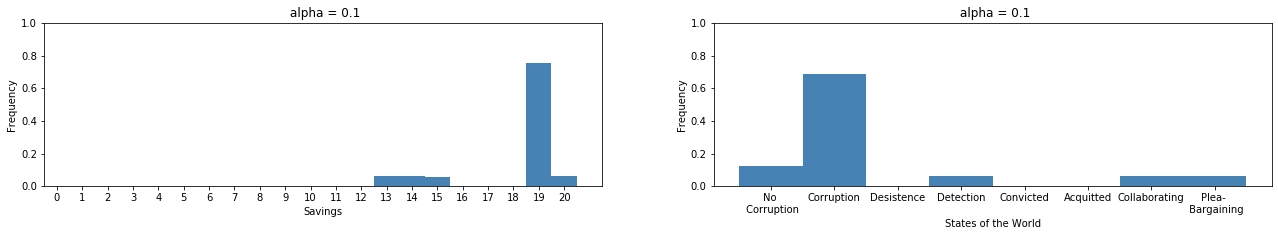

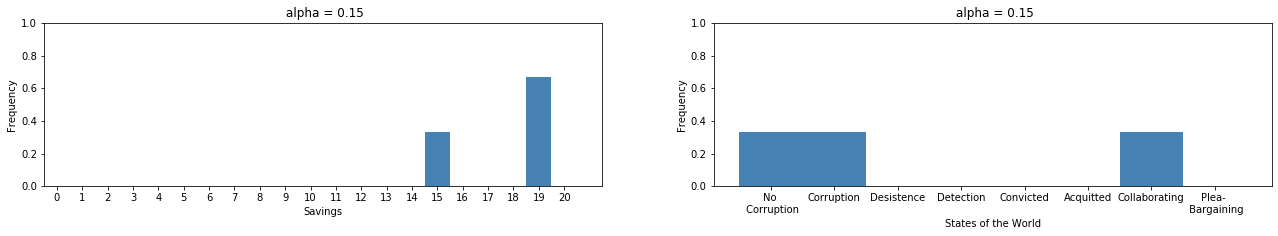

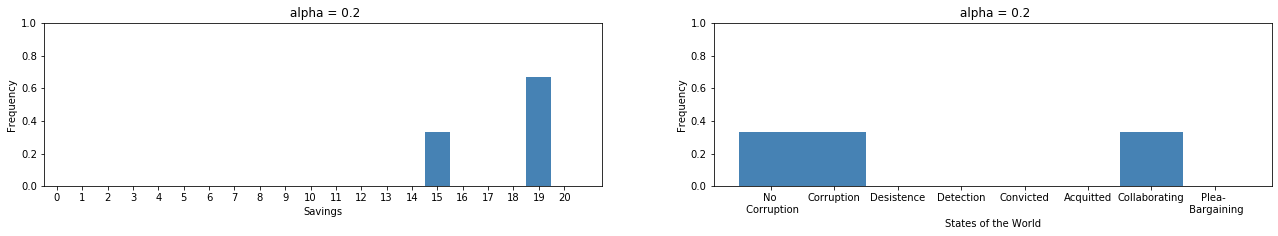

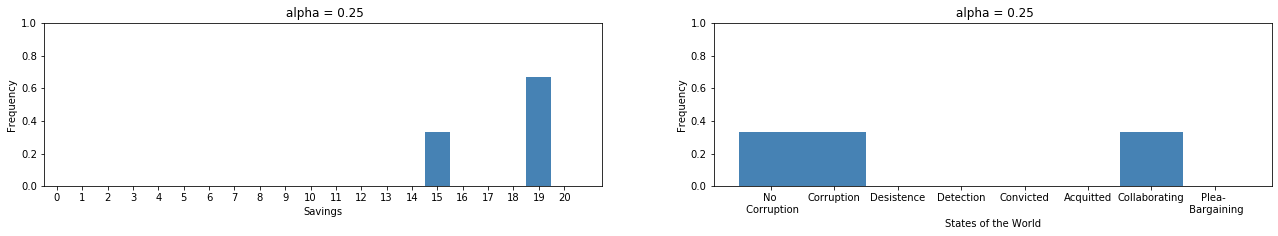

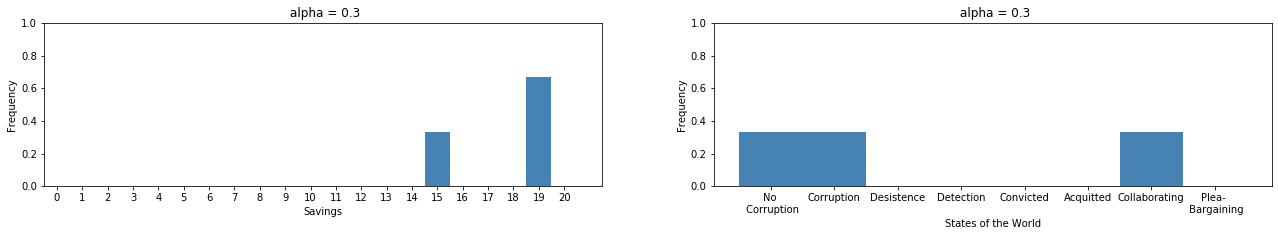

In [105]:
#Plot 1 alphas

alphas = [0.10,0.15,0.2,0.25,0.3]

for i,j in zip(alphas, range(len(alphas))):
    j = Leniency(alpha = i, L_bar = 10, A_bar = 20)
    histogram(j,' alpha = ' + str (i) )


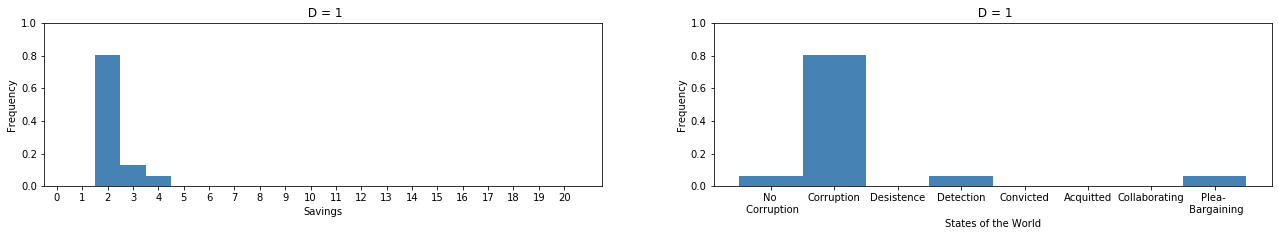

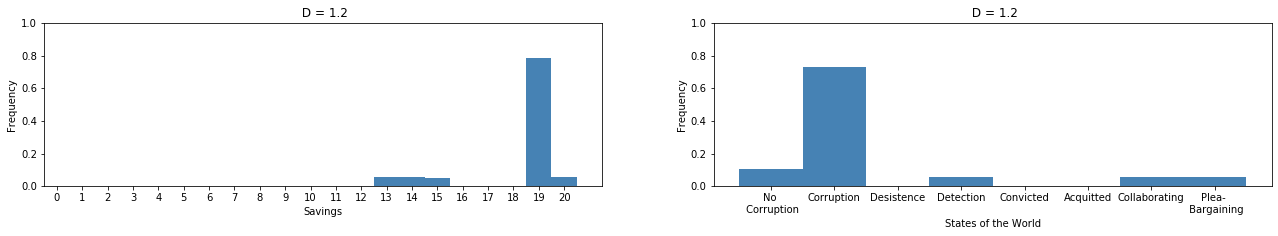

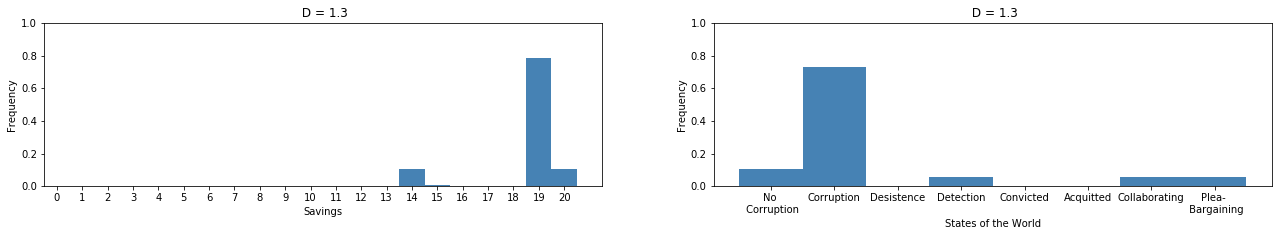

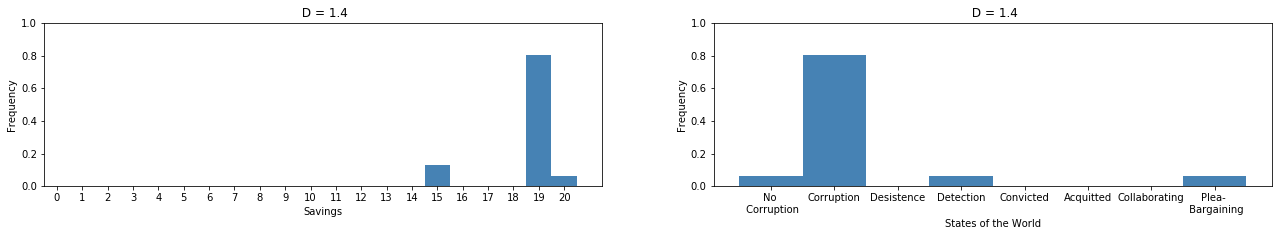

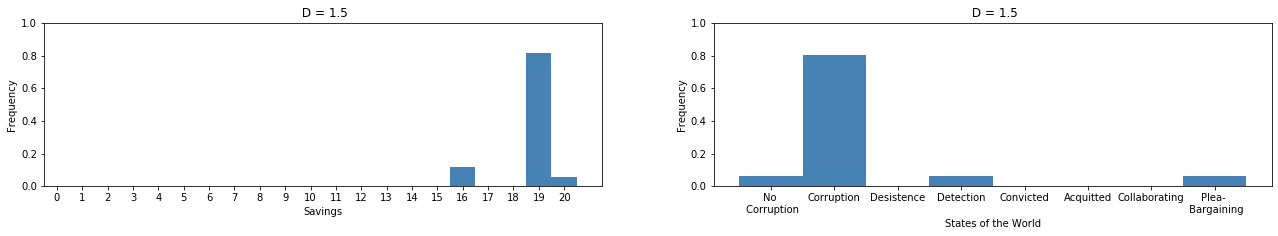

In [ ]:
#Plot 2 Asset Remuneration D (Interests)

Ds = [1, 1.2 , 1.3 , 1.4 , 1.5]

for i,j in zip(Ds, range(len(Ds))):
    j = Leniency(D = i, L_bar = 10, A_bar = 20)
    histogram(j,' D = ' + str (i) )

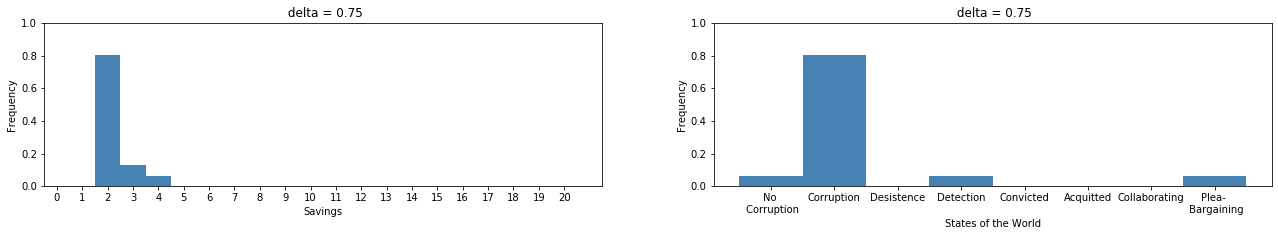

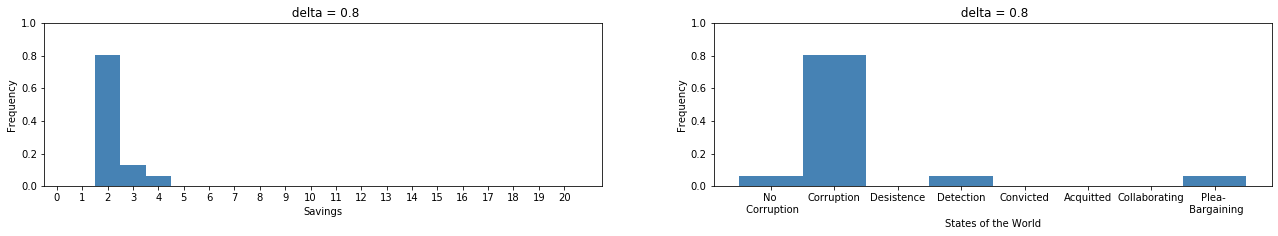

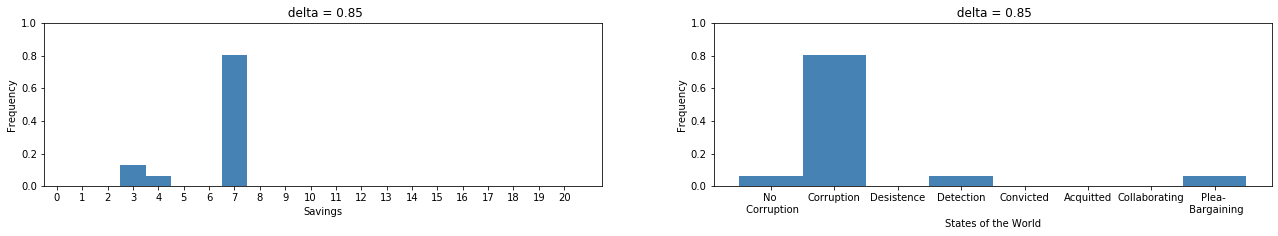

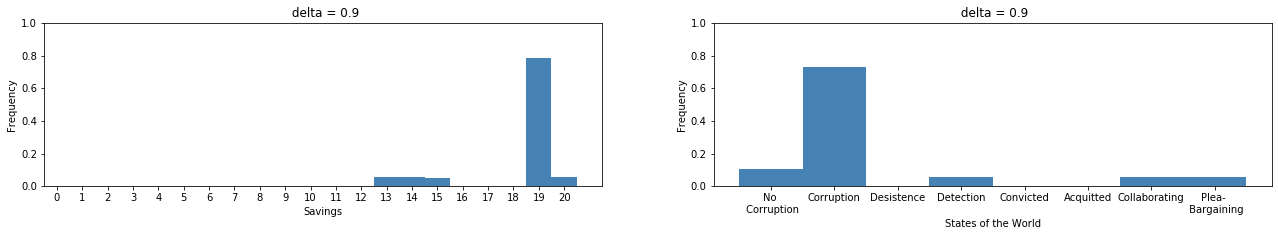

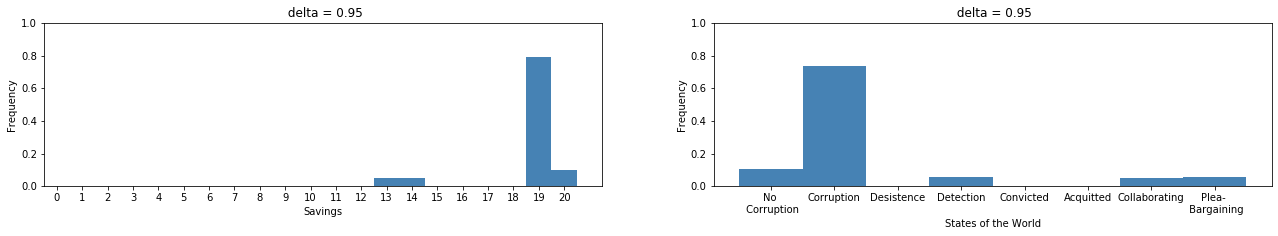

In [ ]:
#Plot 3 Time discount delta

deltas = [0.75, 0.8 , 0.85 , 0.9 , 0.95]

for i,j in zip(deltas, range(len(deltas))):
    j = Leniency(delta = i, L_bar = 10, A_bar = 20)
    histogram(j,' delta = ' + str (i) )


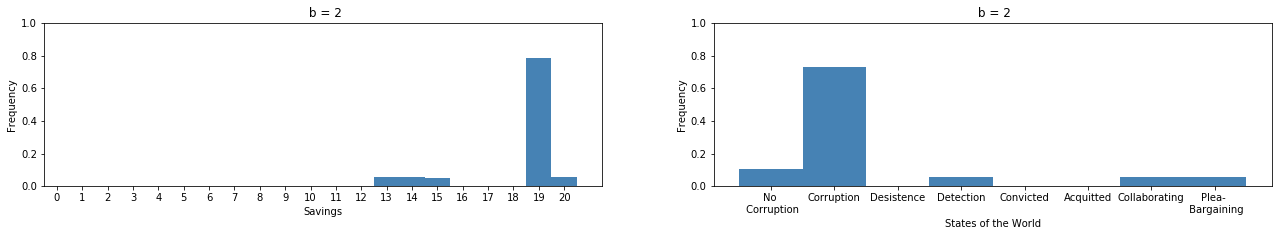

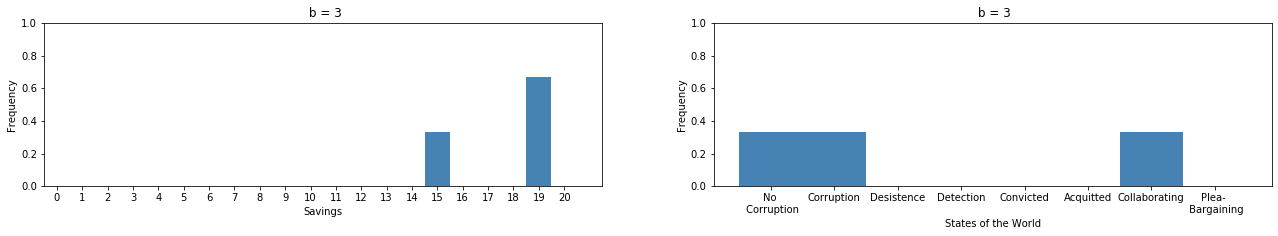

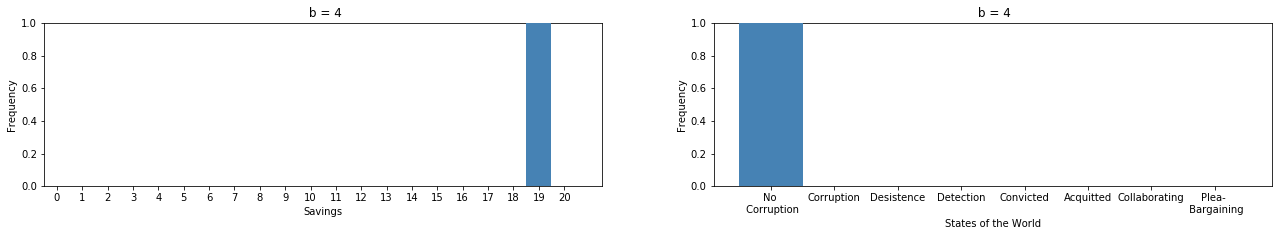

In [108]:
#Plot 5 bribe size b

bs = [2,3,4]

for i,j in zip(bs, range(len(bs))):
    j = Leniency(b = i, L_bar = 10, A_bar = 20)
    histogram(j,' b = ' + str (i) )
    

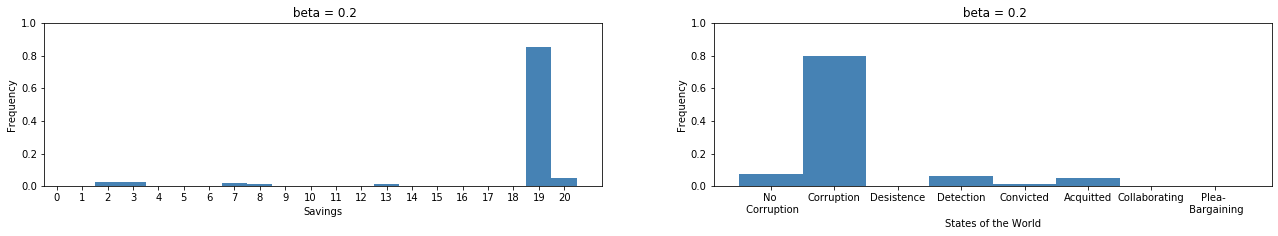

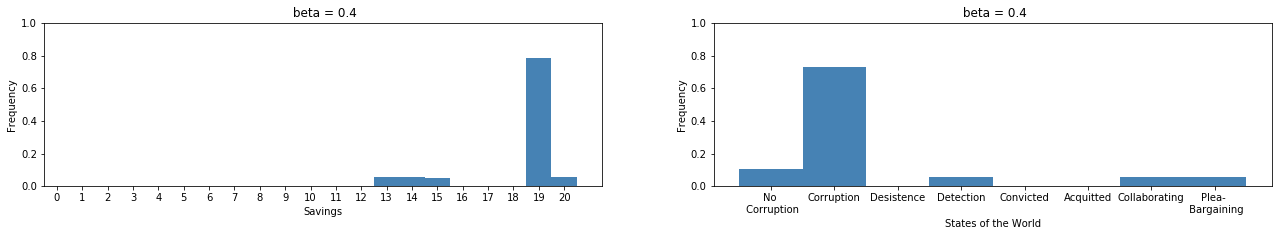

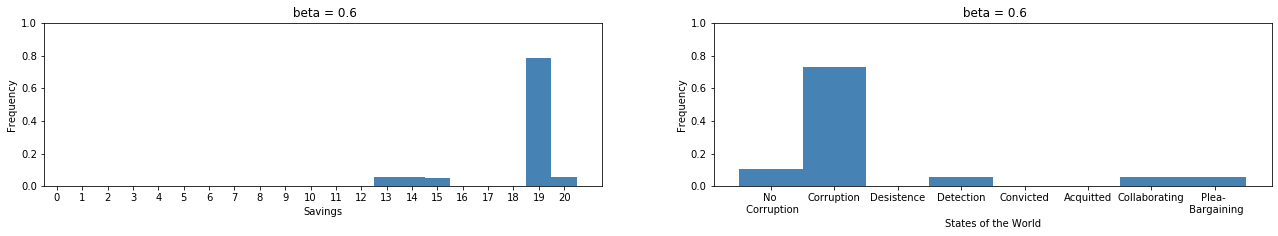

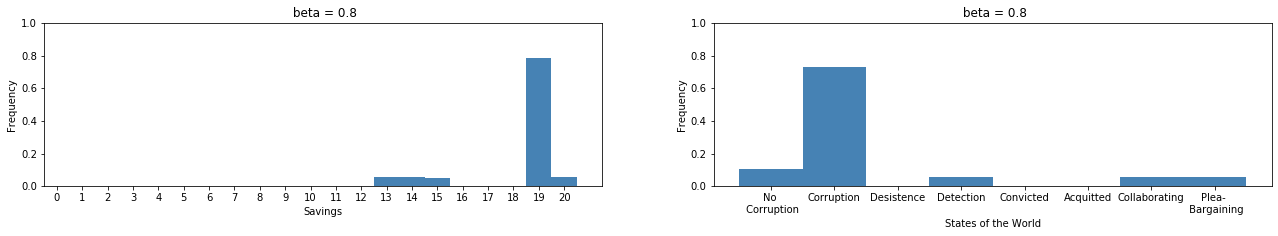

In [109]:
#Plot 6 betas

betas = [0.2,0.4,0.6,0.8]

for i,j in zip(betas, range(len(betas))):
    j = Leniency(beta = i, L_bar = 10, A_bar = 20)
    histogram(j,' beta = ' + str (i) )

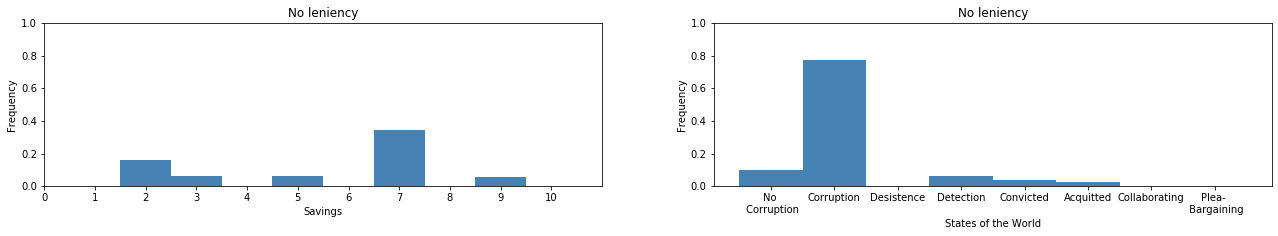

In [71]:
histogram(Leniency(Re = 1, re = 1, Pl = 1 , pl = 1, L_bar = 5, A_bar = 10, eta = 0.1),'No leniency' )
    
    

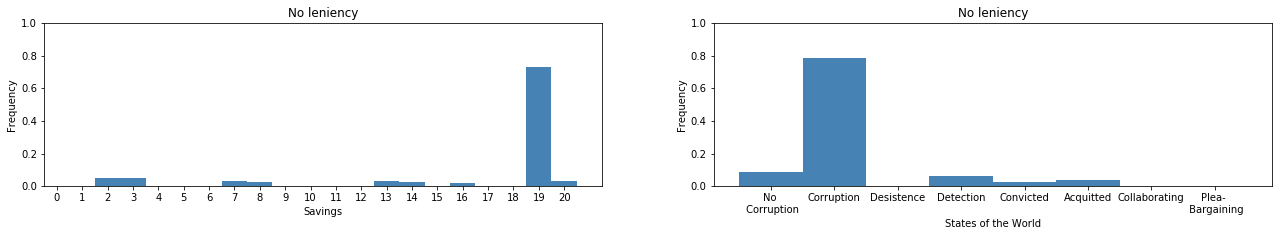

In [111]:
histogram(Leniency(Re = 1, re = 1, Pl = 1 , pl = 1, L_bar = 5, A_bar = 20),'No leniency' )

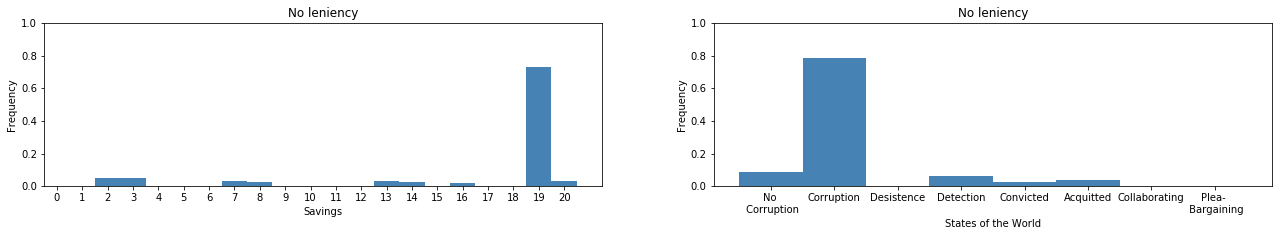

In [125]:
histogram(Leniency(Re = 1, re = 1, Pl = 1 , pl = 1, L_bar = 10, A_bar = 20),'No leniency' )

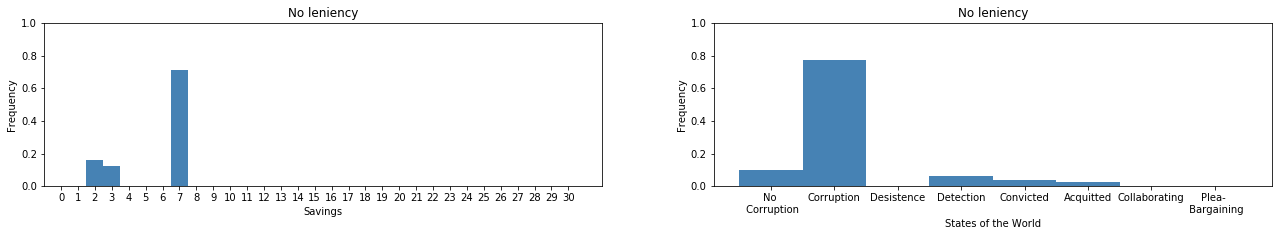

In [80]:
histogram(Leniency(Re = 1, re = 1, Pl = 1 , pl = 1, L_bar = 10, A_bar = 30, eta = 0.9),'No leniency' )

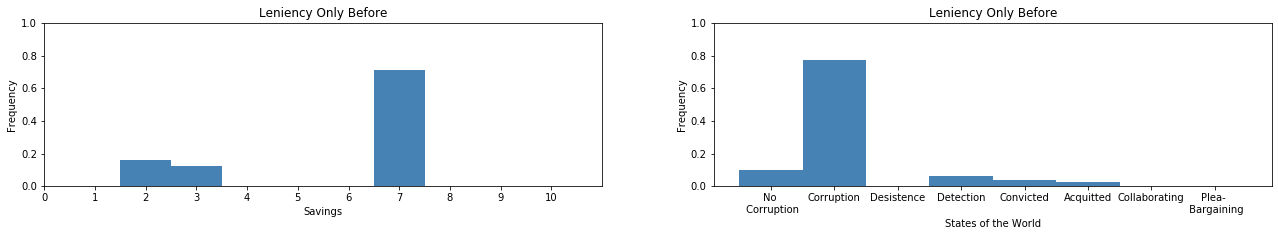

In [91]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 1 , pl = 1, L_bar = 5, A_bar = 10 ),'Leniency Only Before' )

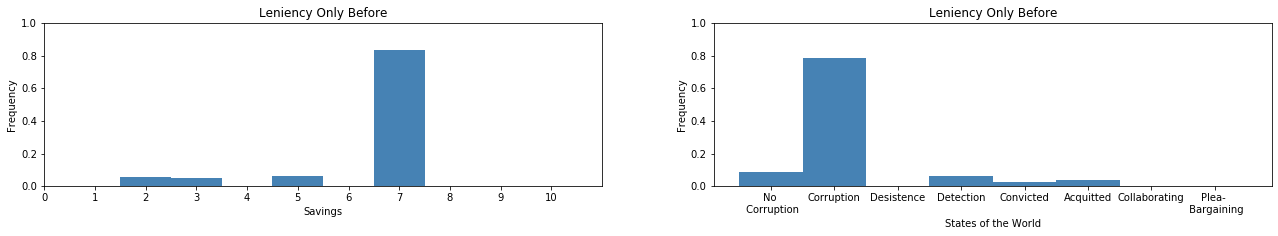

In [110]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 1 , pl = 1, L_bar = 10, A_bar = 10 ),'Leniency Only Before' )

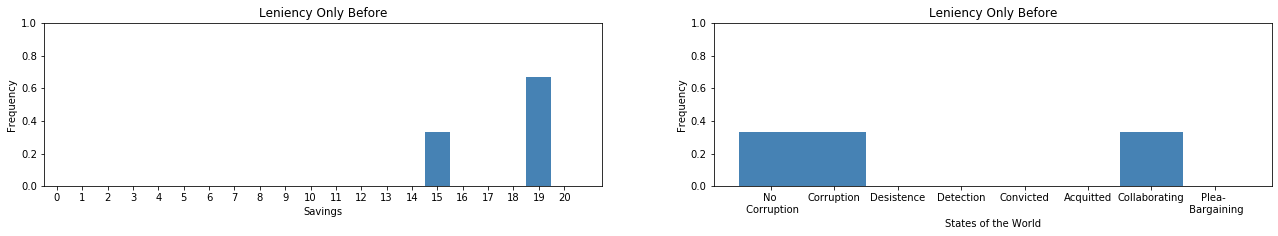

In [83]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 1 , pl = 1, L_bar = 5, A_bar = 20 ),'Leniency Only Before' )

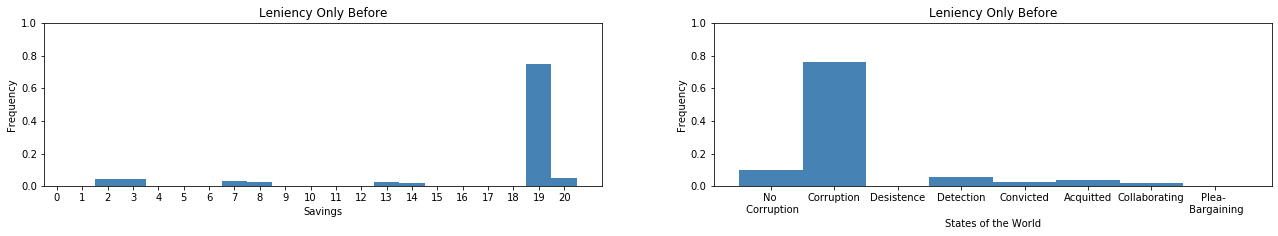

In [126]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 1 , pl = 1, L_bar = 10, A_bar = 20 ),'Leniency Only Before' )

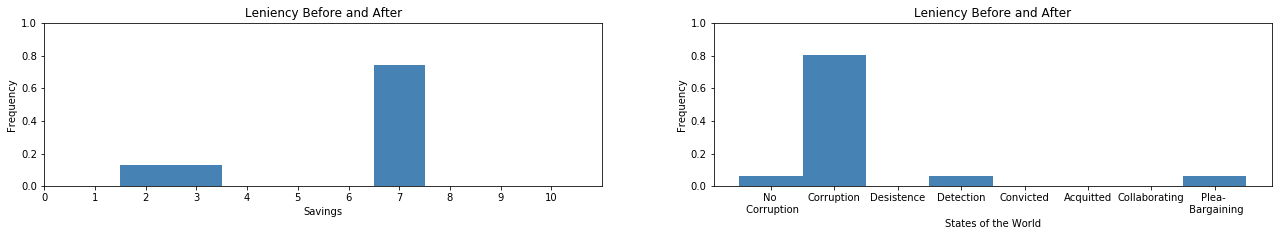

In [92]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 10),'Leniency Before and After' )
    


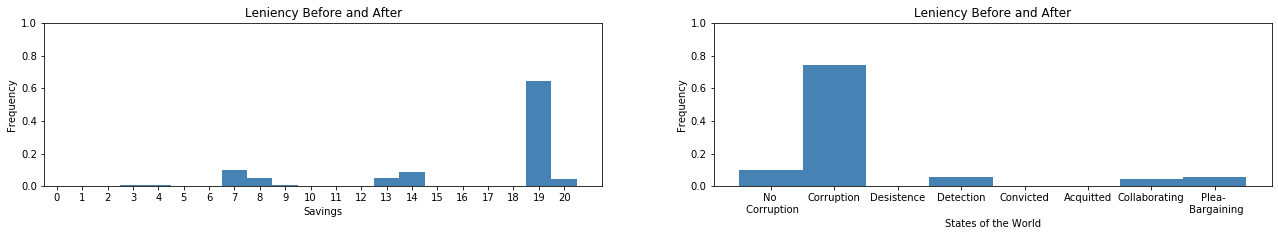

In [90]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 20),'Leniency Before and After' )
    


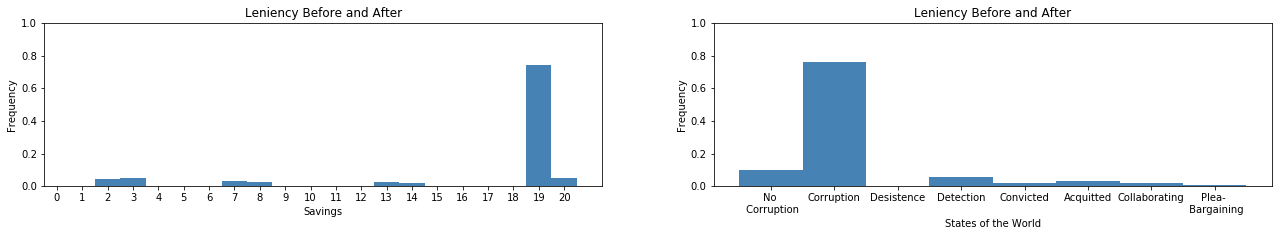

In [127]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 10, A_bar = 20),'Leniency Before and After' )


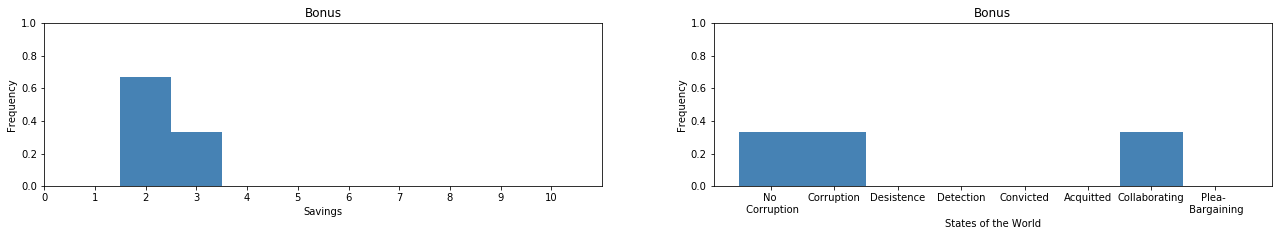

In [74]:
histogram(Leniency(Re = -0.5, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 10),'Bonus' )

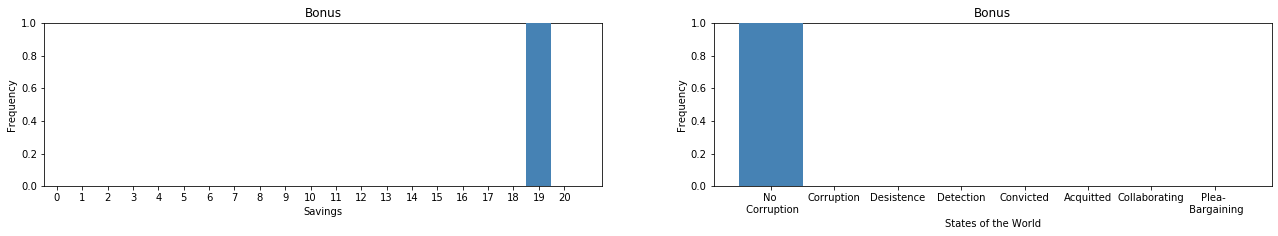

In [93]:
histogram(Leniency(Re = -0.5, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 20),'Bonus' )

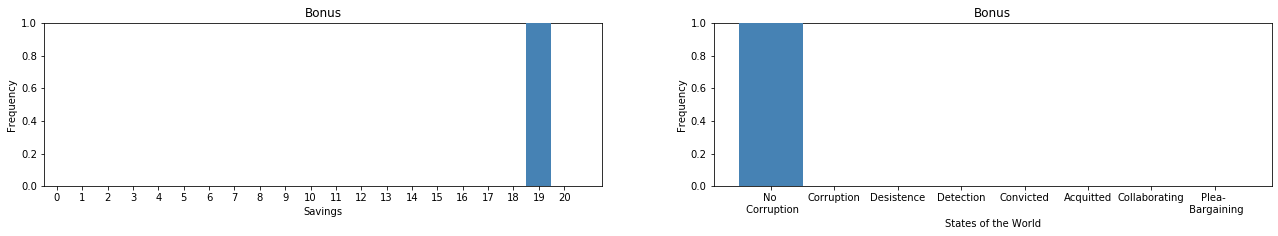

In [128]:
histogram(Leniency(Re = -0.5, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 10, A_bar = 20),'Bonus' )

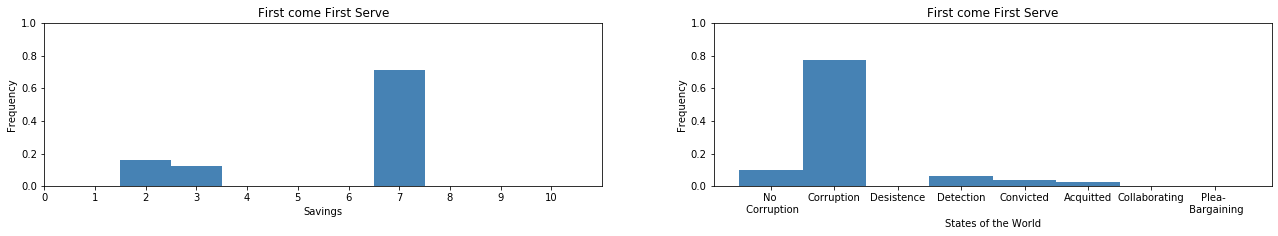

In [75]:
histogram(Leniency(Re = 0, re= 1, Pl = 1 , pl = 1, L_bar = 5, A_bar = 10),'First come First Serve' )

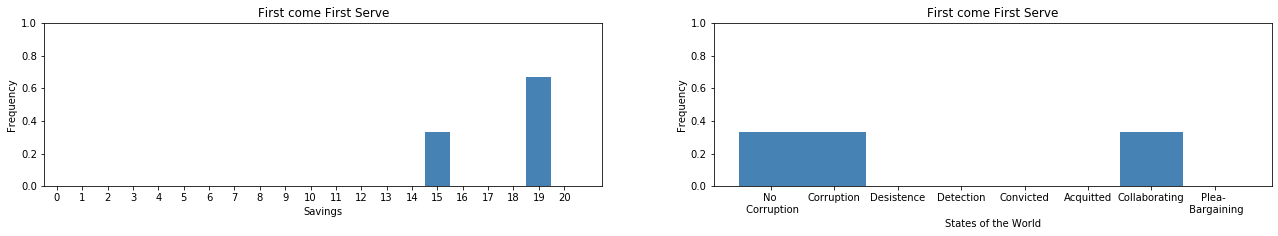

In [94]:
histogram(Leniency(Re = 0, re= 1, Pl = 1 , pl = 1, L_bar = 5, A_bar = 20),'First come First Serve' )

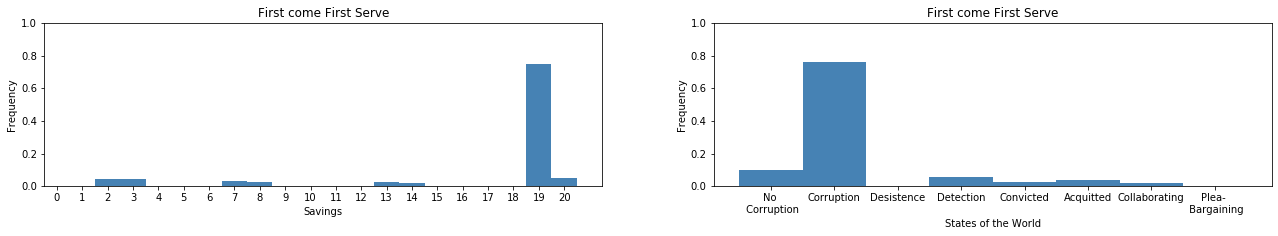

In [129]:
histogram(Leniency(Re = 0, re= 1, Pl = 1 , pl = 1, L_bar = 10, A_bar = 20),'First come First Serve' )

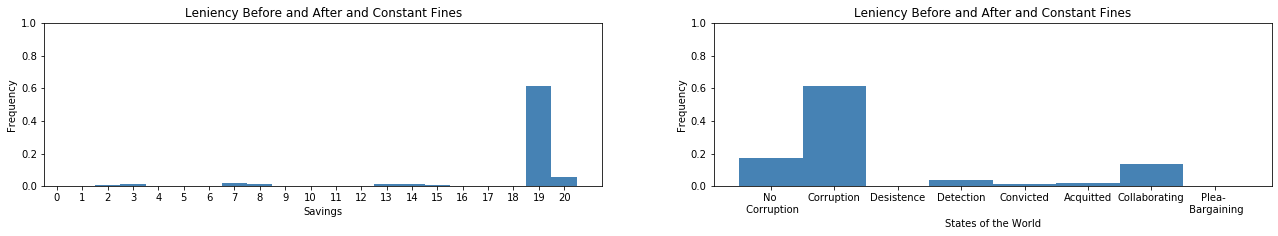

In [114]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 20),'Leniency Before and After and Constant Fines' )

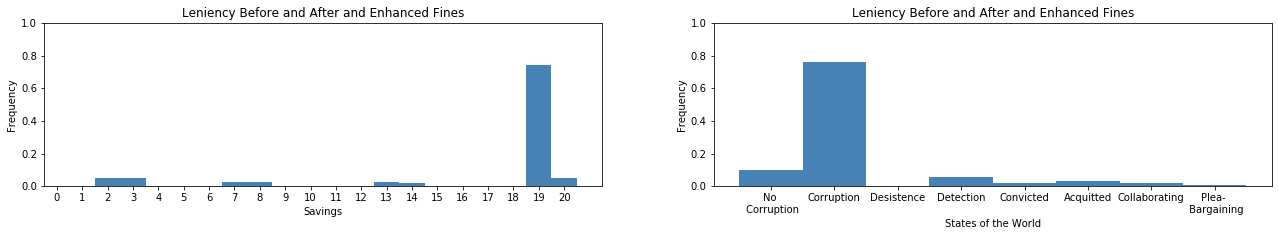

In [117]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 20),'Leniency Before and After and Enhanced Fines' )

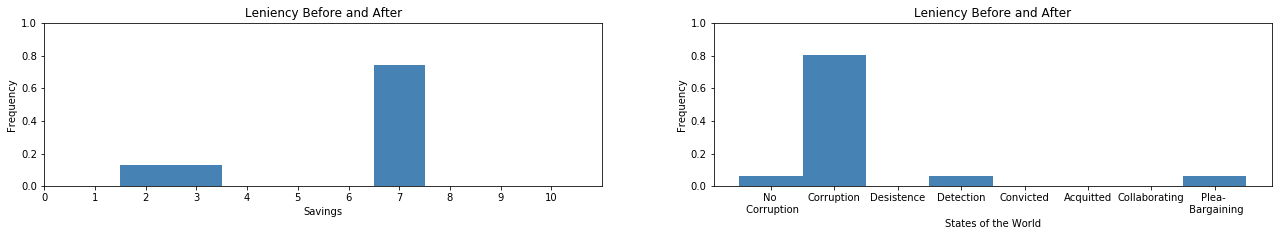

In [118]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 10),'Leniency Before and After' )

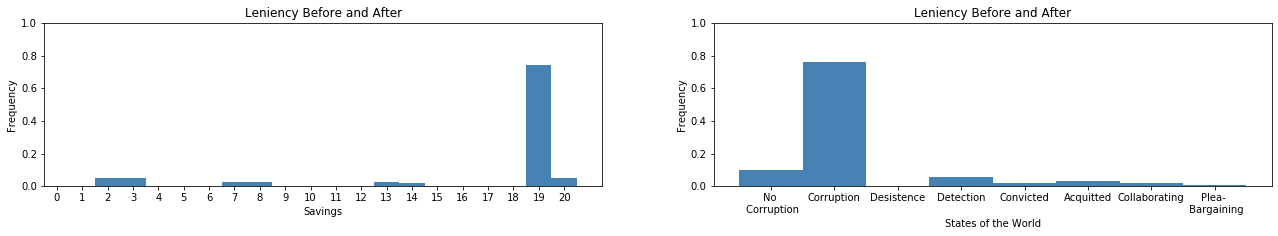

In [119]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 10, A_bar = 20),'Leniency Before and After' )

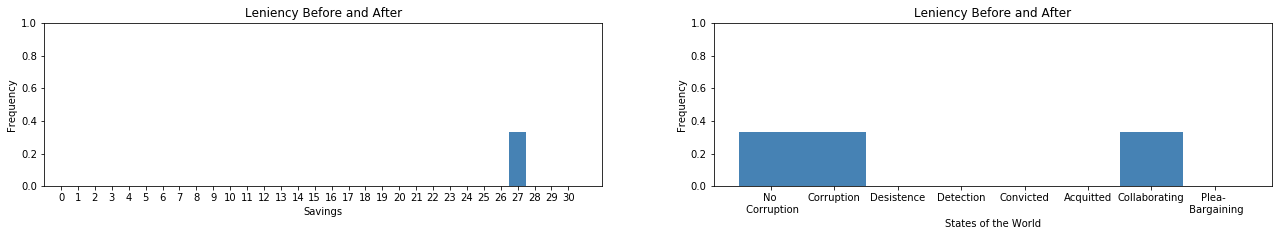

In [120]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 30),'Leniency Before and After' )

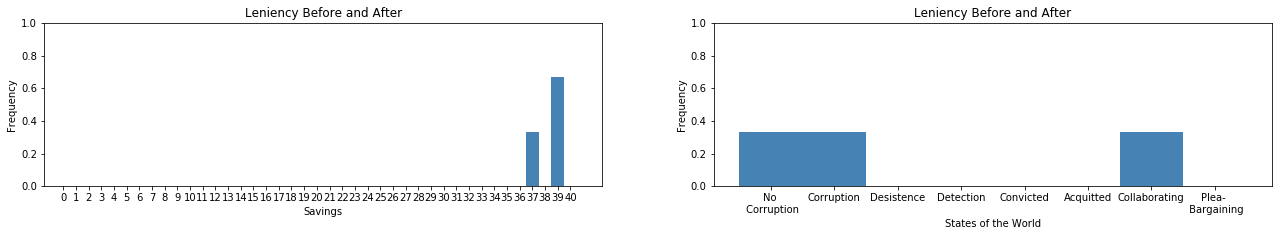

In [121]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 5, A_bar = 40),'Leniency Before and After' )

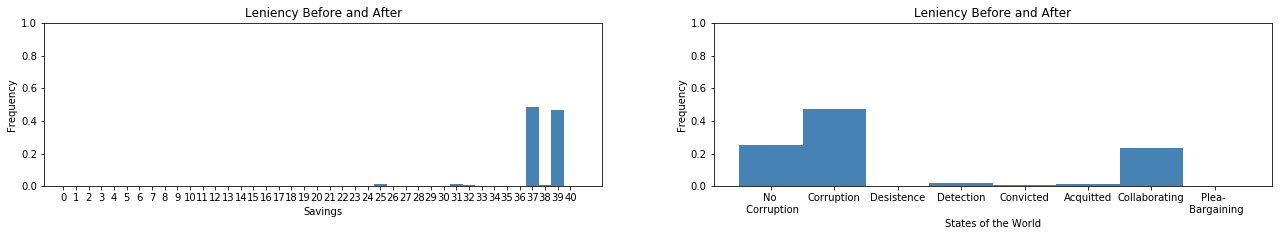

In [124]:
histogram(Leniency(Re = 0, re= 0.5, Pl = 0.6 , pl = 0.8, L_bar = 15, A_bar = 40),'Leniency Before and After' )